Load and Preprocess Your Legal Dataset
Modify the data loading step to ensure contextual sentences are included (optional).



In [24]:
import json
import os
import glob
from sklearn.preprocessing import LabelEncoder

# Define the folder containing your JSON files
json_folder = r'C:\Users\Scholars\Documents\Krunal\project_model\train_data'  # Change this to the correct folder path

# Initialize lists to store sentences and labels
texts = []
labels = []

# Load all JSON files in the folder
for file_path in glob.glob(os.path.join(json_folder, "*.json")):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

        for entry in data:
            rhetorical_roles = entry.get("rhetorical_roles", [])

            for i, role in enumerate(rhetorical_roles):
                current_text = role["text"]
                current_label = role["labels"][0]  # Assuming a single label per span

                # Get previous and next sentences (contextual window)
                prev_text = rhetorical_roles[i - 1]["text"] if i > 0 else ""
                next_text = rhetorical_roles[i + 1]["text"] if i < len(rhetorical_roles) - 1 else ""

                # Combine with contextual information
                contextual_text = f"{prev_text} [SEP] {current_text} [SEP] {next_text}"

                texts.append(contextual_text)
                labels.append(current_label)

print(f"Loaded {len(texts)} contextual text spans from {len(glob.glob(os.path.join(json_folder, '*.json')))} files.")

# Encode rhetorical role labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Save label mapping for later use
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)


Loaded 965 contextual text spans from 30 files.
Label Mapping: {0: np.str_('Arguments'), 1: np.str_('Discussion by the Court'), 2: np.str_('Facts'), 3: np.str_('Issues'), 4: np.str_('Parties involved'), 5: np.str_('Precedent'), 6: np.str_('Ratio of the decision'), 7: np.str_('Ruling by lower court'), 8: np.str_('Ruling by present court'), 9: np.str_('Statute')}


Split Data for Training, Validation, and Testing

In [25]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, encoded_labels, test_size=0.3, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)


Load the Pre-Trained InLegalBERT Model & Tokenizer

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
model_name = "law-ai/InLegalBERT"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_mapping))

print("Model and tokenizer loaded successfully!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at law-ai/InLegalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!


Tokenize the Data -
Tokenize your text and convert it into tensors for training.

In [27]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)


Convert Tokenized Data into a PyTorch Dataset-
Convert the dataset into PyTorch format for fine-tuning.

In [28]:
import torch

class RhetoricalRoleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create PyTorch datasets
train_dataset = RhetoricalRoleDataset(train_encodings, train_labels)
val_dataset = RhetoricalRoleDataset(val_encodings, val_labels)
test_dataset = RhetoricalRoleDataset(test_encodings, test_labels)


Fine-Tune the InLegalBERT Model
Now, we fine-tune the model using Hugging Face's Trainer API`.



In [ ]:
from transformers import Trainer, TrainingArguments, get_linear_schedule_with_warmup, AdamW, EarlyStoppingCallback
from torch.nn import CrossEntropyLoss
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure train_labels exists
if 'train_labels' not in globals():
    raise NameError("train_labels is not defined. Ensure dataset is loaded before running this.")

# Convert train_labels to numpy array
train_labels_np = np.array(train_labels)

# Compute class weights for handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_np),
    y=train_labels_np
)

# Convert to tensor and move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Custom loss function (weighted cross-entropy)
loss_fn = CrossEntropyLoss(weight=class_weights)
"""
# Training arguments with improved hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    run_name="fine_tuned_legal_bert",
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep only the best 3 models
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),  # Enable FP16 only if CUDA is available
)
"""

"""
# Modify training arguments to enable early stopping
training_args = TrainingArguments(
    output_dir='./results',
    run_name="fine_tuned_legal_bert",
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Keep only the best 3 models
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,              # Load best model (lowest val loss)
    metric_for_best_model="loss",             # Use validation loss for comparison
    greater_is_better=False,                  # Lower loss is better
    save_on_each_node=False,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),           # Enable FP16 only if CUDA is available
)

# Early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,                # Stop after 5 consecutive epochs without improvement
    early_stopping_threshold=0.0              # Minimum improvement threshold
)
"""
# Custom optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Scheduler: Linear decay with warm-up
num_training_steps = len(train_dataset) * training_args.num_train_epochs
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

# Compute metrics function
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)  # Get predicted class indices
    labels = p.label_ids  # True labels

    return {
        "precision": precision_score(labels, predictions, average='weighted', zero_division=0),
        "recall": recall_score(labels, predictions, average='weighted', zero_division=0),
        "f1": f1_score(labels, predictions, average='weighted', zero_division=0),
    }

# Custom Trainer to apply weighted loss
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.train_losses = []  # List to store loss values
    
    def on_train_end(self, args, state, control, **kwargs):
        # Log training loss at the end of each epoch
        self.train_losses.append(state.best_metric)
        super().on_train_end(args, state, control, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)  # Use the weighted loss function

        return (loss, outputs) if return_outputs else loss
#"""
# Initialize Trainer with custom loss function
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)
#"""
"""
# Custom Trainer with Early Stopping
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],                # Add early stopping callback
)
"""
# Train the model
trainer.train()
"""
# Save the best model after training
best_model_path = './results/best_model'
trainer.save_model(best_model_path)
print(f"Best model saved at: {best_model_path}")
"""

c:\Users\Scholars\Documents\Krunal\venv1\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\Scholars\Documents\Krunal\venv1\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,2.302100,2.333221,0.022483,0.089655,0.032706
2,2.336800,2.328963,0.020890,0.082759,0.030455
3,2.326700,2.318638,0.020727,0.082759,0.030247
4,2.335000,2.306331,0.018967,0.082759,0.028796
5,2.292200,2.292467,0.018611,0.082759,0.028513
6,2.326300,2.277033,0.016297,0.075862,0.025941
7,2.279500,2.258488,0.277073,0.082759,0.037569
8,2.219400,2.238818,0.102381,0.082759,0.037060
9,2.232600,2.215838,0.239337,0.103448,0.056102
10,2.116100,2.196341,0.117255,0.103448,0.056128


C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for k

'\n# Save the best model after training\nbest_model_path = \'./results/best_model\'\ntrainer.save_model(best_model_path)\nprint(f"Best model saved at: {best_model_path}")\n'

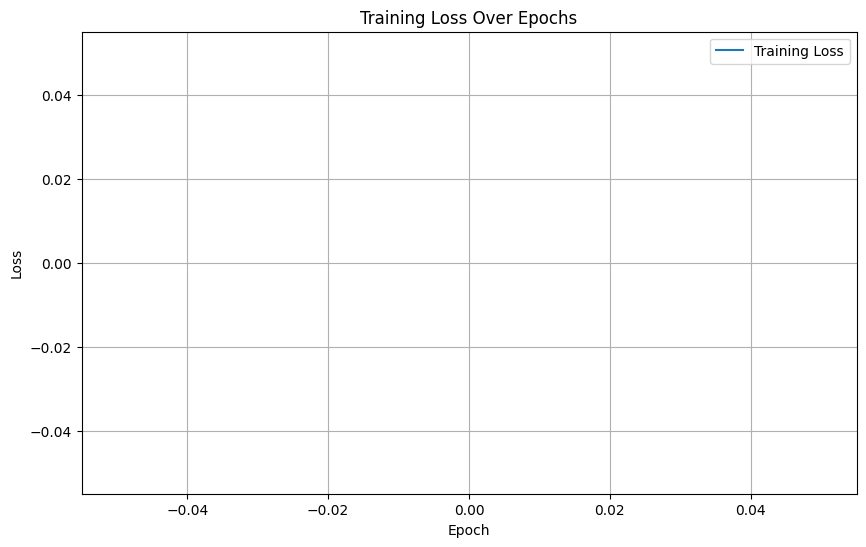

In [30]:
# After training, plot the training losses
import matplotlib.pyplot as plt  # Importing matplotlib for plotting loss graph

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(trainer.train_losses) + 1), trainer.train_losses, label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

 Evaluate the Model -
Check how well the model performs after training.

In [31]:
from sklearn.metrics import classification_report

# Predict on test data
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)

# Print classification report
print(classification_report(test_labels, pred_labels, target_names=label_mapping.values()))


C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


                         precision    recall  f1-score   support

              Arguments       0.63      0.71      0.67        17
Discussion by the Court       0.70      0.61      0.66        31
                  Facts       0.60      0.65      0.62        23
                 Issues       0.00      0.00      0.00         3
       Parties involved       0.88      0.78      0.82         9
              Precedent       0.94      0.80      0.86        20
  Ratio of the decision       0.54      0.64      0.58        11
  Ruling by lower court       0.60      0.60      0.60        15
Ruling by present court       0.77      1.00      0.87        10
                Statute       0.83      0.83      0.83         6

               accuracy                           0.69       145
              macro avg       0.65      0.66      0.65       145
           weighted avg       0.69      0.69      0.69       145



Save and Load the Fine-Tuned Model
Once the model is fine-tuned, save it for future use.

C:\Users\Scholars\AppData\Local\Temp\ipykernel_22884\3811113397.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


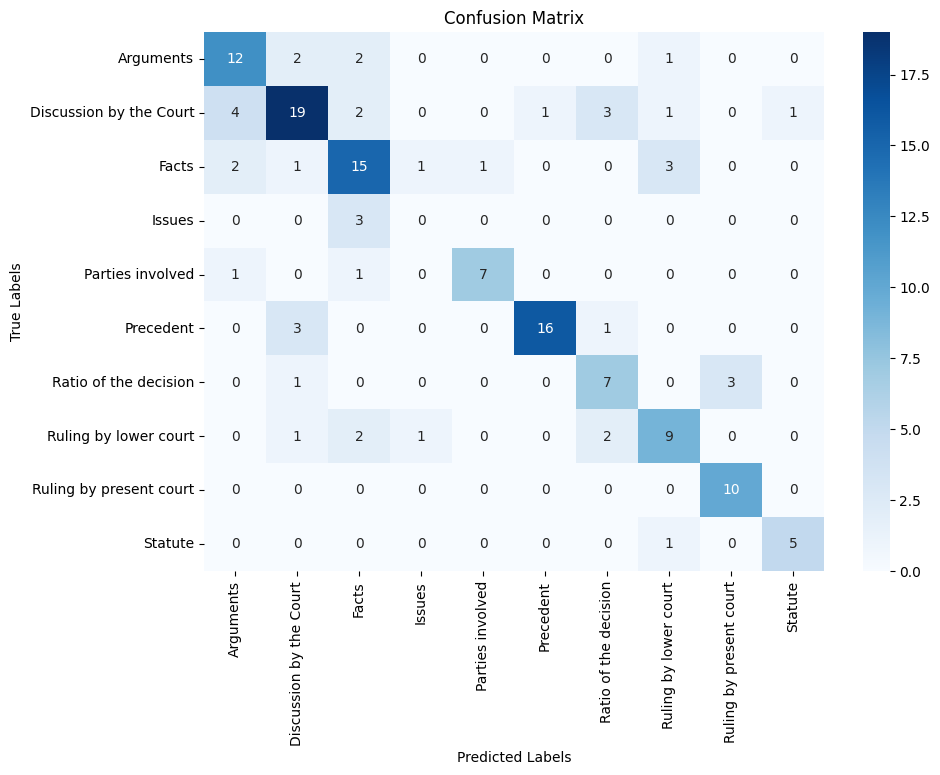

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [33]:
# Save model and tokenizer
model.save_pretrained(r"C:\Users\Scholars\Documents\Krunal\project_model\trained_model\trained_model_4")
tokenizer.save_pretrained(r"C:\Users\Scholars\Documents\Krunal\project_model\trained_model\trained_model_4")


('C:\\Users\\Scholars\\Documents\\Krunal\\project_model\\trained_model\\trained_model_4\\tokenizer_config.json',
 'C:\\Users\\Scholars\\Documents\\Krunal\\project_model\\trained_model\\trained_model_4\\special_tokens_map.json',
 'C:\\Users\\Scholars\\Documents\\Krunal\\project_model\\trained_model\\trained_model_4\\vocab.txt',
 'C:\\Users\\Scholars\\Documents\\Krunal\\project_model\\trained_model\\trained_model_4\\added_tokens.json',
 'C:\\Users\\Scholars\\Documents\\Krunal\\project_model\\trained_model\\trained_model_4\\tokenizer.json')

To reload the model for inference:


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define the directory where the model and tokenizer were saved
output_dir = r'C:\trained_model'

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

print("Model and tokenizer loaded successfully!")

#model = AutoModelForSequenceClassification.from_pretrained("C:\Users\Scholars\Documents\Krunal\project_model\train_file\compensated\results\checkpoint-1100")
#tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_legal_bert")



Model and tokenizer loaded successfully!


Use the Model for Predictions -
Use the fine-tuned InLegalBERT model to classify rhetorical roles in new legal text.

In [29]:
# Example text for inference
example_text = "Bench: Vineet Saran, Uday Umesh Lalit"

# Tokenize the input text
inputs = tokenizer(example_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Perform inference (prediction)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to predicted class
predicted_class = torch.argmax(logits, dim=-1).item()

# Map predicted class back to label
predicted_label = label_mapping[predicted_class]
print(f"Predicted label: {predicted_label}")


Predicted label: Bench


### Using the fine-tuned model to predict the rhetorical roles for a legal judgement given in pdf document

In [ ]:
### This block gives the labelled document keeping the rhetorical roles as subheadings
"""
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import fitz  # PyMuPDF
import nltk
from collections import defaultdict

# Ensure NLTK sentence tokenizer is downloaded
nltk.download('punkt')

# Load fine-tuned model and tokenizer
output_dir = r'C:\Users\KRUNAL\Documents\project_training\trained_model'
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.eval()

# Updated label mapping
label_mapping = {
    0: "Applicant",
    1: "Arguments by Applicant",
    2: "Arguments by Respondent",
    3: "Author",
    4: "Bench",
    5: "Discussion by the Court",
    6: "Discussion by the court",
    7: "Facts",
    8: "Issues",
    9: "Precedent",
    10: "Ratio of the decision",
    11: "Respondent",
    12: "Ruling by the lower court",
    13: "Ruling by the present court",
    14: "Statute"
}

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

def classify_sentences(text):
    """Classify rhetorical roles of sentences and organize them by labels."""
    sentences = nltk.sent_tokenize(text)
    classified = defaultdict(list)

    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).item()
            predicted_label = label_mapping.get(predicted_class, "Unknown")
            classified[predicted_label].append(sentence)
    
    return classified

def save_results_to_txt(classified_results, output_file):
    """Save results in a structured, easy-to-read format for LLM summarization."""
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write("### Rhetorical Role Classification of Sentences ###\n\n")
        for label, sentences in classified_results.items():
            file.write(f"## {label} ##\n")
            for idx, sentence in enumerate(sentences, 1):
                file.write(f"{idx}. {sentence}\n")
            file.write("\n" + "-"*80 + "\n\n")

def main(pdf_path, output_file):
    """Main function to extract, classify, and save results."""
    print(f"Extracting text from PDF: {pdf_path}")
    text = extract_text_from_pdf(pdf_path)
    
    print("Classifying sentences...")
    classified_results = classify_sentences(text)
    
    print(f"Saving results to: {output_file}")
    save_results_to_txt(classified_results, output_file)
    
    print(f"Classification completed. Results saved to {output_file}")

# Example usage:
pdf_file_path = r'c:\Users\KRUNAL\Documents\project_training\pdf_1.PDF'  # Replace with your actual PDF path
output_txt_path = r'c:\Users\KRUNAL\Documents\project_training\classified_rhetorical_summary.txt'  # Output file path

main(pdf_file_path, output_txt_path)
"""


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 287-288: truncated \UXXXXXXXX escape (3863967469.py, line 2)

In [ ]:
## Code for inputting a pdf file and getting a text file with labelled rhetorical roles

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import fitz  # PyMuPDF
import spacy

# Load spaCy model
nlp = spacy.load("en_core_web_lg")

# Load fine-tuned model and tokenizer
output_dir = r'C:\trained_model'
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.eval()

# Updated label mapping
label_mapping = {
    0: "Applicant",
    1: "Arguments by Applicant",
    2: "Arguments by Respondent",
    3: "Author",
    4: "Bench",
    5: "Discussion by the Court",
    6: "Discussion by the court",
    7: "Facts",
    8: "Issues",
    9: "Precedent",
    10: "Ratio of the decision",
    11: "Respondent",
    12: "Ruling by the lower court",
    13: "Ruling by the present court",
    14: "Statute"
}

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

def tokenize_sentences_spacy(text):
    """Tokenize sentences using spaCy."""
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    return sentences

def classify_sentences(sentences):
    """Classify rhetorical roles and maintain original flow."""
    annotated_sentences = []

    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).item()
            predicted_label = label_mapping.get(predicted_class, "Unknown")
            annotated_sentences.append(f"[{predicted_label}] {sentence}")
    
    return annotated_sentences

def save_results_to_txt(annotated_sentences, output_file):
    """Save results in a structured, LLM-friendly format without disturbing the original flow."""
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write("### Annotated Rhetorical Roles in Legal Judgment ###\n\n")
        for line in annotated_sentences:
            file.write(line + "\n")

def main(pdf_path, output_file):
    """Main function to extract, tokenize, classify, and save results."""
    print(f"Extracting text from PDF: {pdf_path}")
    text = extract_text_from_pdf(pdf_path)
    
    print("Tokenizing sentences using spaCy...")
    sentences = tokenize_sentences_spacy(text)
    
    print("Classifying sentences...")
    annotated_sentences = classify_sentences(sentences)
    
    print(f"Saving results to: {output_file}")
    save_results_to_txt(annotated_sentences, output_file)
    
    print(f"Classification completed. Results saved to {output_file}")

# Example usage:
pdf_file_path = r'c:\Users\KRUNAL\Documents\project_training\pdf_1.PDF'  # Replace with your actual PDF path
output_txt_path = r'c:\Users\KRUNAL\Documents\project_training\annotated_legal_judgment_spacy.txt'  # Output file path

main(pdf_file_path, output_txt_path)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KRUNAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extracting text from PDF: c:\Users\KRUNAL\Documents\project_training\pdf_1.PDF
Classifying sentences...
Saving results to: c:\Users\KRUNAL\Documents\project_training\annotated_legal_judgment.txt
Classification completed. Results saved to c:\Users\KRUNAL\Documents\project_training\annotated_legal_judgment.txt
